# Image Segmentation by Unsupervised Learning

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2


## load data

In [3]:
directory_data  = './'
filename_data   = 'assignment_10_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

image_train     = data['image_train']
mask_train      = data['mask_train']

image_test      = data['image_test']
mask_test       = data['mask_test']

num_data_train  = image_train.shape[0]
num_data_test   = image_test.shape[0]

In [4]:
print('*************************************************')
print('size of x_train :', image_train.shape)
print('size of y_train :', mask_train.shape)
print('*************************************************')
print('size of x_test :', image_test.shape)
print('size of y_test :', mask_test.shape)
print('*************************************************')

*************************************************
size of x_train : (1000, 32, 32)
size of y_train : (1000, 32, 32)
*************************************************
size of x_test : (1000, 32, 32)
size of y_test : (1000, 32, 32)
*************************************************


## plot data

In [5]:
def plot_image(title, image, mask):
    
    nRow = 2
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
    
    for c in range(nCol):
        axes[0, c].imshow(image[c], cmap='gray')
        axes[1, c].imshow(mask[c], cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

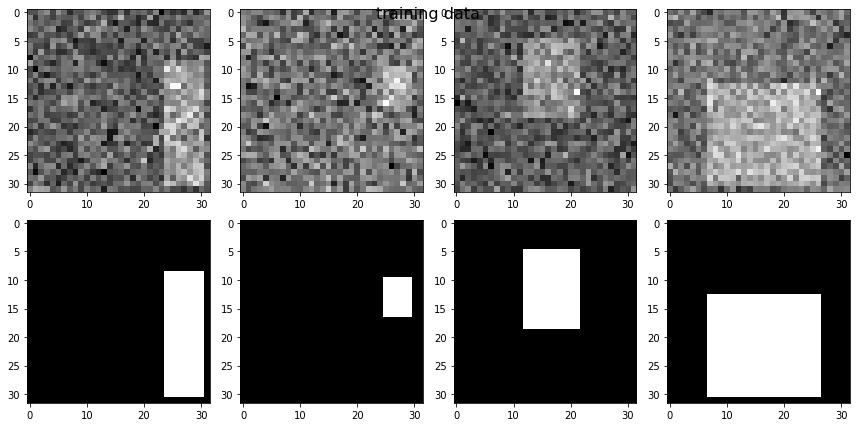

In [6]:
plot_image('training data', image_train, mask_train)

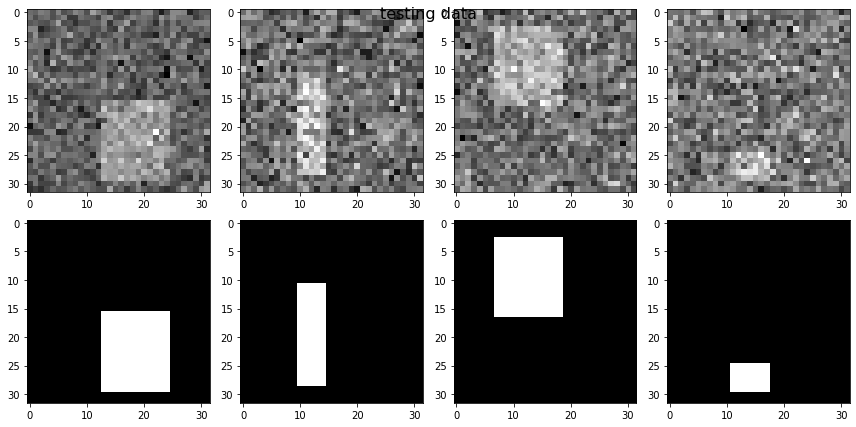

In [7]:
plot_image('testing data', image_test, mask_test)

## custom data loader for the PyTorch framework

In [8]:
class dataset(Dataset):
    
    def __init__(self, image, mask, use_transform=False):
        
        self.image          = image
        self.mask           = mask
        self.use_transform  = use_transform
    
    def __getitem__(self, index):
        
        image   = self.image[index]
        mask    = self.mask[index]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        mask    = torch.FloatTensor(mask).unsqueeze(dim=0)

        # apply a data augmentation scheme
        if self.use_transform:
            # ==================================================
            # add codes for applying data augmentation 
            #

                image   = transforms.RandomRotation(degrees = 45)(image)
                mask    = transforms.RandomRotation(degrees = 45)(mask)
            
            #    
            # ==================================================

        return (image, mask)
    
    def __len__(self):

        number_image = self.image.shape[0]

        return number_image

## setting device

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
print(device)

cuda


## construct datasets and dataloaders for testing and testing

In [11]:
# ==================================================
# determine the mini-batch size
#
size_minibatch      = 10 
#
# ==================================================

dataset_train       = dataset(image_train, mask_train, True)
dataset_test        = dataset(image_test, mask_test, False)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=False)

## construct a neural network 

In [12]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1, bias=True),  
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.decoder_layer2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.decoder_layer1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid(),
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
            self.encoder_layer1,
            self.encoder_layer2,
            self.decoder_layer2, 
            self.decoder_layer1,
        )

        self.initialize_weight()

    def forward(self,x):
    
        out = self.network(x)
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

## build the network

In [13]:
model       = Network().to(device)

# ==================================================
# determine the optimiser and its associated hyper-parameters
#
learning_rate   = 0.01
alpha           = 0.001
number_epoch    = 1000
optimizer       = torch.optim.SGD(model.parameters(), lr=learning_rate)
#
# ==================================================

## compute the prediction

In [14]:
def compute_prediction(model, data):

    prediction = model(data)

    return prediction

## compute the loss

In [15]:
def compute_estimate(data, prediction):
    # ==================================================
    # fill up the blank
    #
    (b, c, h, w) = data.size()
    estimate = torch.zeros(2, b, c).to(device)

    estimate[0] = torch.sum(torch.sum(data*prediction, axis=2), axis=2)/ torch.sum(torch.sum(prediction, axis=2) , axis=2)
    estimate[1] = torch.sum(torch.sum(data*(1-prediction), axis=2) ,axis=2) / torch.sum(torch.sum((1-prediction), axis=2), axis=2)

    #
    # ==================================================

    return estimate

In [16]:
def compute_loss_data_fidelity(data, prediction):
    # ==================================================
    # fill up the blank
    # 
    (b, c, h, w) = data.size()
    estimate = compute_estimate(data, prediction)
    estimate_in = torch.unsqueeze(torch.unsqueeze(estimate[0], dim = -1), dim = -1)
    estimate_out = torch.unsqueeze(torch.unsqueeze(estimate[1], dim = -1), dim = -1)
    residual_in = torch.square(data - estimate_in)
    residual_out = torch.square(data - estimate_out)
    fidelity_in = torch.sum(prediction*residual_in)
    fidelity_out = torch.sum((1-prediction)*residual_out)
    loss = (fidelity_in + fidelity_out)/(b*c*h*w)

    #
    # ==================================================

    return loss

In [17]:
def compute_loss_regularization(prediction):
    # ==================================================
    # fill up the blank
    # 
    (b, c, h, w) = prediction.size()
    gradient_yaxis = torch.abs(prediction[:,:,1:,:]- prediction[:,:,:-1,:]).sum()
    gradient_xaxis = torch.abs(prediction[:,:,:,1:]- prediction[:,:,:,:-1]).sum()
    loss = (gradient_yaxis+gradient_xaxis)/(b*c*h*w)

    #
    # ==================================================
    
    return loss

In [18]:
def compute_loss(data, prediction, alpha):
    # ==================================================
    # fill up the blank
    #

    loss_data_fidelity  = compute_loss_data_fidelity(data, prediction)
    loss_regularization = compute_loss_regularization(prediction)
    loss                = loss_data_fidelity + alpha*loss_regularization

    #
    # ==================================================

    return (loss, loss_data_fidelity, loss_regularization)

## compute the loss value

In [19]:
def compute_loss_value(loss):
    
    loss_value = loss.item()
    
    return loss_value

## compute the accuracy

In [20]:
def compute_accuracy(prediction, mask):
    
    prediction1 = prediction.squeeze(axis=1)
    prediction2 = 1 - prediction.squeeze(axis=1)
    binary1     = (prediction1 >= 0.5)
    binary2     = (prediction2 >= 0.5)
    mask        = mask.squeeze(axis=1).bool()
    
    intersection1   = (binary1 & mask).float().sum((1, 2))
    intersection2   = (binary2 & mask).float().sum((1, 2))
    union1          = (binary1 | mask).float().sum((1, 2))
    union2          = (binary2 | mask).float().sum((1, 2))

    eps         = 1e-8
    correct1    = (intersection1 + eps) / (union1 + eps)
    correct2    = (intersection2 + eps) / (union2 + eps)
    accuracy1   = correct1.mean() * 100.0
    accuracy2   = correct2.mean() * 100.0
    
    accuracy    = torch.max(accuracy1, accuracy2)
    accuracy    = accuracy.cpu() 
    
    return accuracy

## Variable for the learning curves

In [21]:
loss_train_mean     = np.zeros(number_epoch)
loss_train_std      = np.zeros(number_epoch)
accuracy_train_mean = np.zeros(number_epoch)
accuracy_train_std  = np.zeros(number_epoch)

loss_test_mean      = np.zeros(number_epoch)
loss_test_std       = np.zeros(number_epoch)
accuracy_test_mean  = np.zeros(number_epoch)
accuracy_test_std   = np.zeros(number_epoch)

loss_train_data_fidelity_mean   = np.zeros(number_epoch)
loss_train_data_fidelity_std    = np.zeros(number_epoch)
loss_train_regularization_mean  = np.zeros(number_epoch)
loss_train_regularization_std   = np.zeros(number_epoch)

loss_test_data_fidelity_mean    = np.zeros(number_epoch)
loss_test_data_fidelity_std     = np.zeros(number_epoch)
loss_test_regularization_mean   = np.zeros(number_epoch)
loss_test_regularization_std    = np.zeros(number_epoch)

## train

In [22]:
def train(model, optimizer, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    accuracy_epoch              = []

    model.train()

    for index_batch, (image, mask) in enumerate(dataloader):

        image       = image.to(device)
        mask        = mask.to(device)
        
        # ==================================================
        # fill up the blank
        #
        prediction  = compute_prediction(model, image)
        (loss, loss_data_fidelity, loss_regularization) = compute_loss(image, prediction, alpha)
        
        loss_value                  = compute_loss_value(loss)
        loss_data_fidelity_value    = compute_loss_value(loss_data_fidelity)
        loss_regularization_value   = compute_loss_value(loss_regularization)
        accuracy                    = compute_accuracy(prediction, mask)
        #
        # ==================================================
        
        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        accuracy_epoch.append(accuracy)

        # update the model    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    accuracy_mean   = np.mean(accuracy_epoch)
    accuracy_std    = np.std(accuracy_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    accuracy            = {'mean' : accuracy_mean, 'std' : accuracy_std}

    return (loss, loss_data_fidelity, loss_regularization, accuracy)

## test

In [23]:
def test(model, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    accuracy_epoch              = []

    model.eval()

    for index_batch, (image, mask) in enumerate(dataloader):

        image       = image.to(device)
        mask        = mask.to(device)
        
        # ==================================================
        # fill up the blank
        #
        prediction  = compute_prediction(model, image)
        (loss, loss_data_fidelity, loss_regularization) = compute_loss(image, prediction, alpha)
        
        loss_value                  = compute_loss_value(loss)
        loss_data_fidelity_value    = compute_loss_value(loss_data_fidelity)
        loss_regularization_value   = compute_loss_value(loss_regularization)
        accuracy                    = compute_accuracy(prediction, mask)
        #
        # ==================================================

        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        accuracy_epoch.append(accuracy)

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    accuracy_mean   = np.mean(accuracy_epoch)
    accuracy_std    = np.std(accuracy_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    accuracy            = {'mean' : accuracy_mean, 'std' : accuracy_std}

    return (loss, loss_data_fidelity, loss_regularization, accuracy)

## train and test

In [24]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, loss_data_fidelity_train, loss_regularization_train, accuracy_train) = train(model, optimizer, dataloader_train)

    loss_train_mean[i]  = loss_train['mean']
    loss_train_std[i]   = loss_train['std']

    loss_train_data_fidelity_mean[i]    = loss_data_fidelity_train['mean']
    loss_train_data_fidelity_std[i]     = loss_data_fidelity_train['std']

    loss_train_regularization_mean[i]   = loss_regularization_train['mean']
    loss_train_regularization_std[i]    = loss_regularization_train['std']

    accuracy_train_mean[i]  = accuracy_train['mean']
    accuracy_train_std[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, loss_data_fidelity_test, loss_regularization_test, accuracy_test) = test(model, dataloader_test)

    loss_test_mean[i]  = loss_test['mean']
    loss_test_std[i]   = loss_test['std']

    loss_test_data_fidelity_mean[i]    = loss_data_fidelity_test['mean']
    loss_test_data_fidelity_std[i]     = loss_data_fidelity_test['std']

    loss_test_regularization_mean[i]   = loss_regularization_test['mean']
    loss_test_regularization_std[i]    = loss_regularization_test['std']

    accuracy_test_mean[i]  = accuracy_test['mean']
    accuracy_test_std[i]   = accuracy_test['std']

100%|██████████| 1000/1000 [27:56<00:00,  1.68s/it]


---

## functions for presenting the results

---

In [25]:
def function_result_01():
    
    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [26]:
def function_result_02():
    
    title           = 'loss - data fidelity (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean - loss_train_data_fidelity_std, loss_train_data_fidelity_mean + loss_train_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [27]:
def function_result_03():
    
    title           = 'loss - regularization (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_regularization_mean)), loss_train_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_regularization_mean)), loss_train_regularization_mean - loss_train_regularization_std, loss_train_regularization_mean + loss_train_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [28]:
def function_result_04():
    
    title           = 'loss (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_mean)), loss_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_mean)), loss_test_mean - loss_test_std, loss_test_mean + loss_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [29]:
def function_result_05():
    
    title           = 'loss - data fidelity (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean - loss_test_data_fidelity_std, loss_test_data_fidelity_mean + loss_test_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [30]:
def function_result_06():
    
    title           = 'loss - regularization (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_regularization_mean)), loss_test_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_regularization_mean)), loss_test_regularization_mean - loss_test_regularization_std, loss_test_regularization_mean + loss_test_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [31]:
def function_result_07():
    
    title           = 'accuracy (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_train_mean)), accuracy_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_train_mean)), accuracy_train_mean - accuracy_train_std, accuracy_train_mean + accuracy_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [32]:
def function_result_08():
    
    title           = 'accuracy (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_test_mean)), accuracy_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_test_mean)), accuracy_test_mean - accuracy_test_std, accuracy_test_mean + accuracy_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [33]:
def function_result_09():

    nRow = 10
    nCol = 4 
    size = 3 
    
    title = 'training results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    number_data = len(dataset_train)
    index_image = np.linspace(0, number_data-1, nRow).astype(int)

    image       = torch.FloatTensor(dataset_train.image[index_image]).unsqueeze(dim=1).to(device)
    mask        = torch.FloatTensor(dataset_train.mask[index_image]).unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, image)

    image       = image.detach().cpu().squeeze(axis=1)
    mask        = mask.detach().cpu().squeeze(axis=1)
    prediction  = prediction.detach().cpu().squeeze(axis=1)
    binary      = (prediction >= 0.5)

    for r in range(nRow):

            axes[r, 0].imshow(image[r], cmap='gray')
            axes[r, 1].imshow(prediction[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 2].imshow(binary[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 3].imshow(mask[r], cmap='gray', vmin=0, vmax=1)

            axes[r, 0].xaxis.set_visible(False)
            axes[r, 1].xaxis.set_visible(False)
            axes[r, 2].xaxis.set_visible(False)
            axes[r, 3].xaxis.set_visible(False)
            
            axes[r, 0].yaxis.set_visible(False)
            axes[r, 1].yaxis.set_visible(False)
            axes[r, 2].yaxis.set_visible(False)
            axes[r, 3].yaxis.set_visible(False)
            
    plt.tight_layout()
    plt.show()

In [34]:
def function_result_10():
    
    nRow = 10
    nCol = 4 
    size = 3 

    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    number_data = len(dataset_test)
    index_image = np.linspace(0, number_data-1, nRow).astype(int)
    
    image       = torch.FloatTensor(dataset_test.image[index_image]).unsqueeze(dim=1).to(device)
    mask        = torch.FloatTensor(dataset_test.mask[index_image]).unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, image)

    image       = image.detach().cpu().squeeze(axis=1)
    mask        = mask.detach().cpu().squeeze(axis=1)
    prediction  = prediction.detach().cpu().squeeze(axis=1)
    binary      = (prediction >= 0.5)

    for r in range(nRow):
    
            axes[r, 0].imshow(image[r], cmap='gray')
            axes[r, 1].imshow(prediction[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 2].imshow(binary[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 3].imshow(mask[r], cmap='gray', vmin=0, vmax=1)

            axes[r, 0].xaxis.set_visible(False)
            axes[r, 1].xaxis.set_visible(False)
            axes[r, 2].xaxis.set_visible(False)
            axes[r, 3].xaxis.set_visible(False)
            
            axes[r, 0].yaxis.set_visible(False)
            axes[r, 1].yaxis.set_visible(False)
            axes[r, 2].yaxis.set_visible(False)
            axes[r, 3].yaxis.set_visible(False)
            
    plt.tight_layout()
    plt.show()

In [35]:
def function_result_11():
    
    print('final training accuracy = %9.8f' % (accuracy_train_mean[-1]))

In [36]:
def function_result_12():
    
    print('final testing accuracy = %9.8f' % (accuracy_test_mean[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



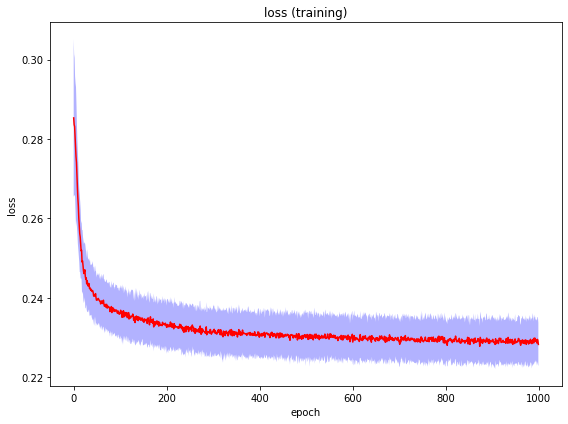


################################################################################
#
# RESULT # 02
#
################################################################################



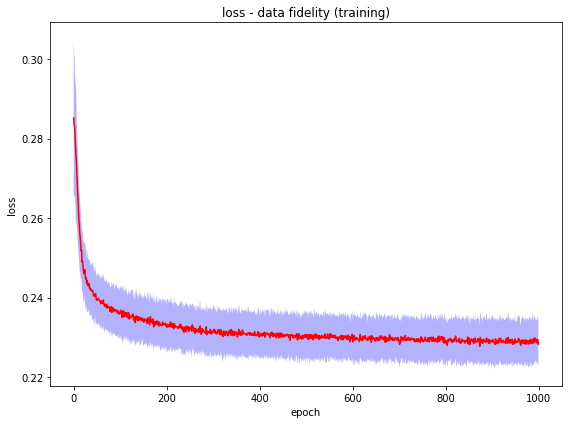


################################################################################
#
# RESULT # 03
#
################################################################################



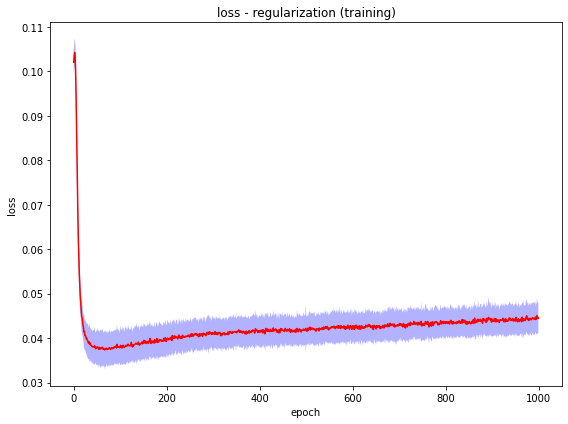


################################################################################
#
# RESULT # 04
#
################################################################################



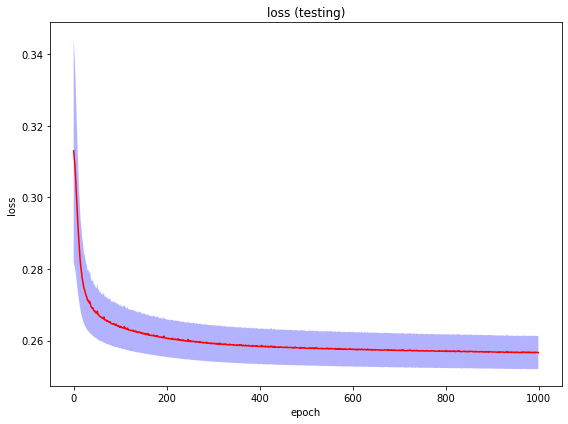


################################################################################
#
# RESULT # 05
#
################################################################################



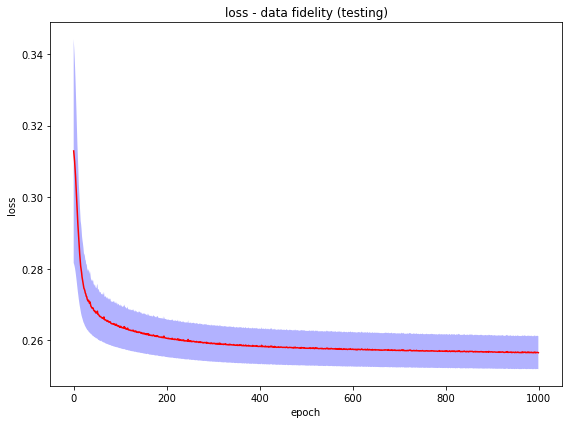


################################################################################
#
# RESULT # 06
#
################################################################################



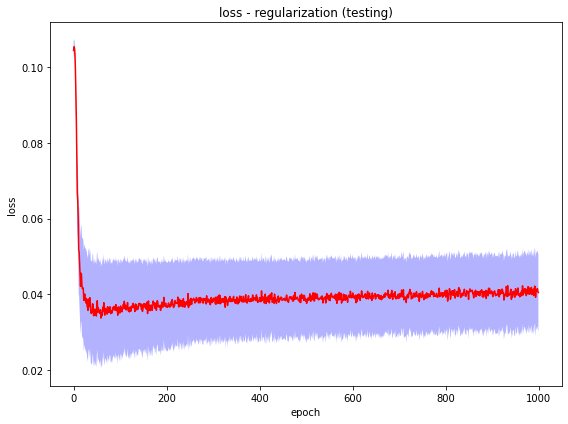


################################################################################
#
# RESULT # 07
#
################################################################################



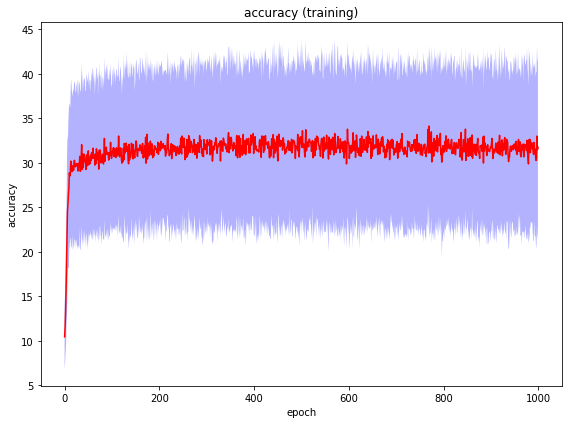


################################################################################
#
# RESULT # 08
#
################################################################################



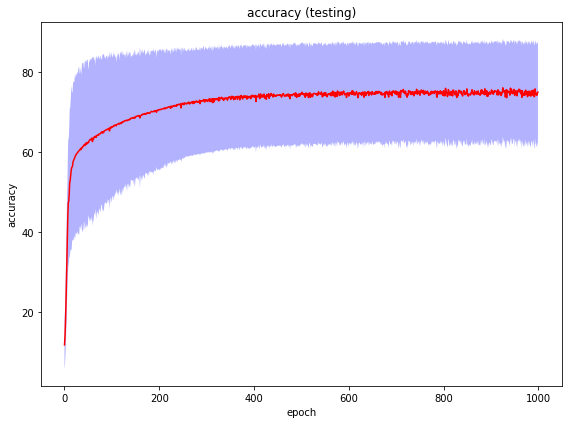


################################################################################
#
# RESULT # 09
#
################################################################################



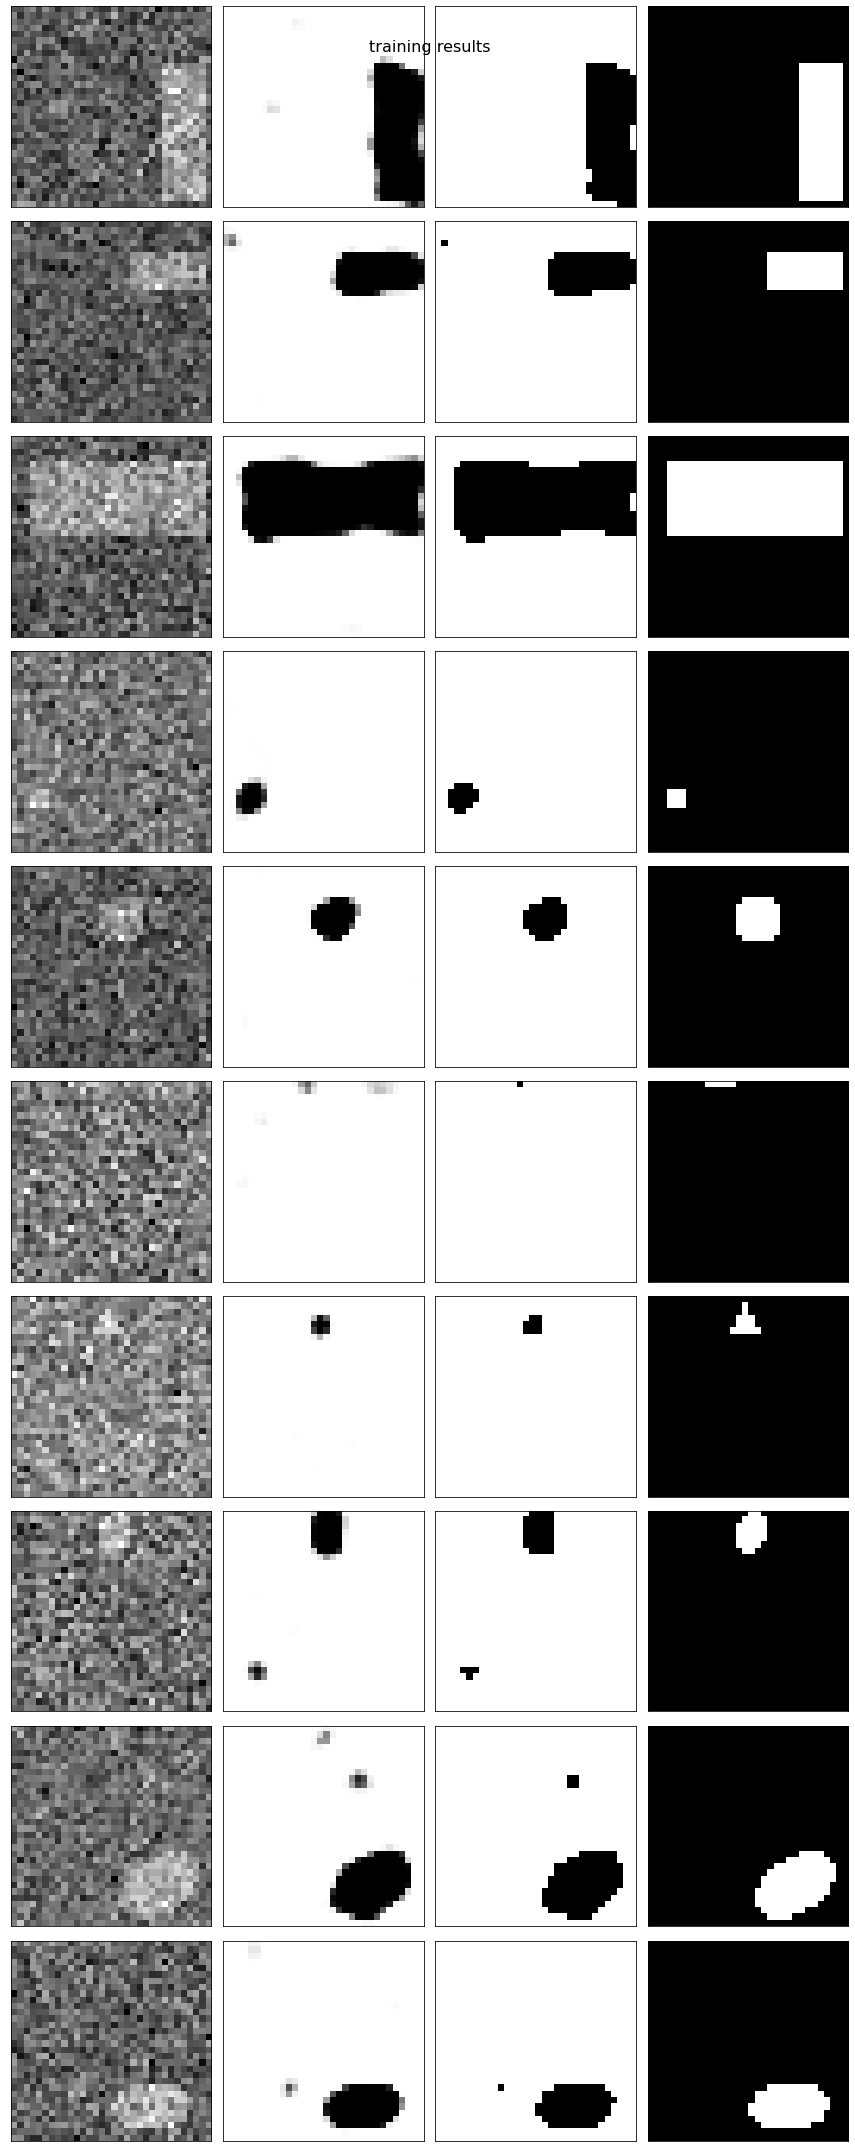


################################################################################
#
# RESULT # 10
#
################################################################################



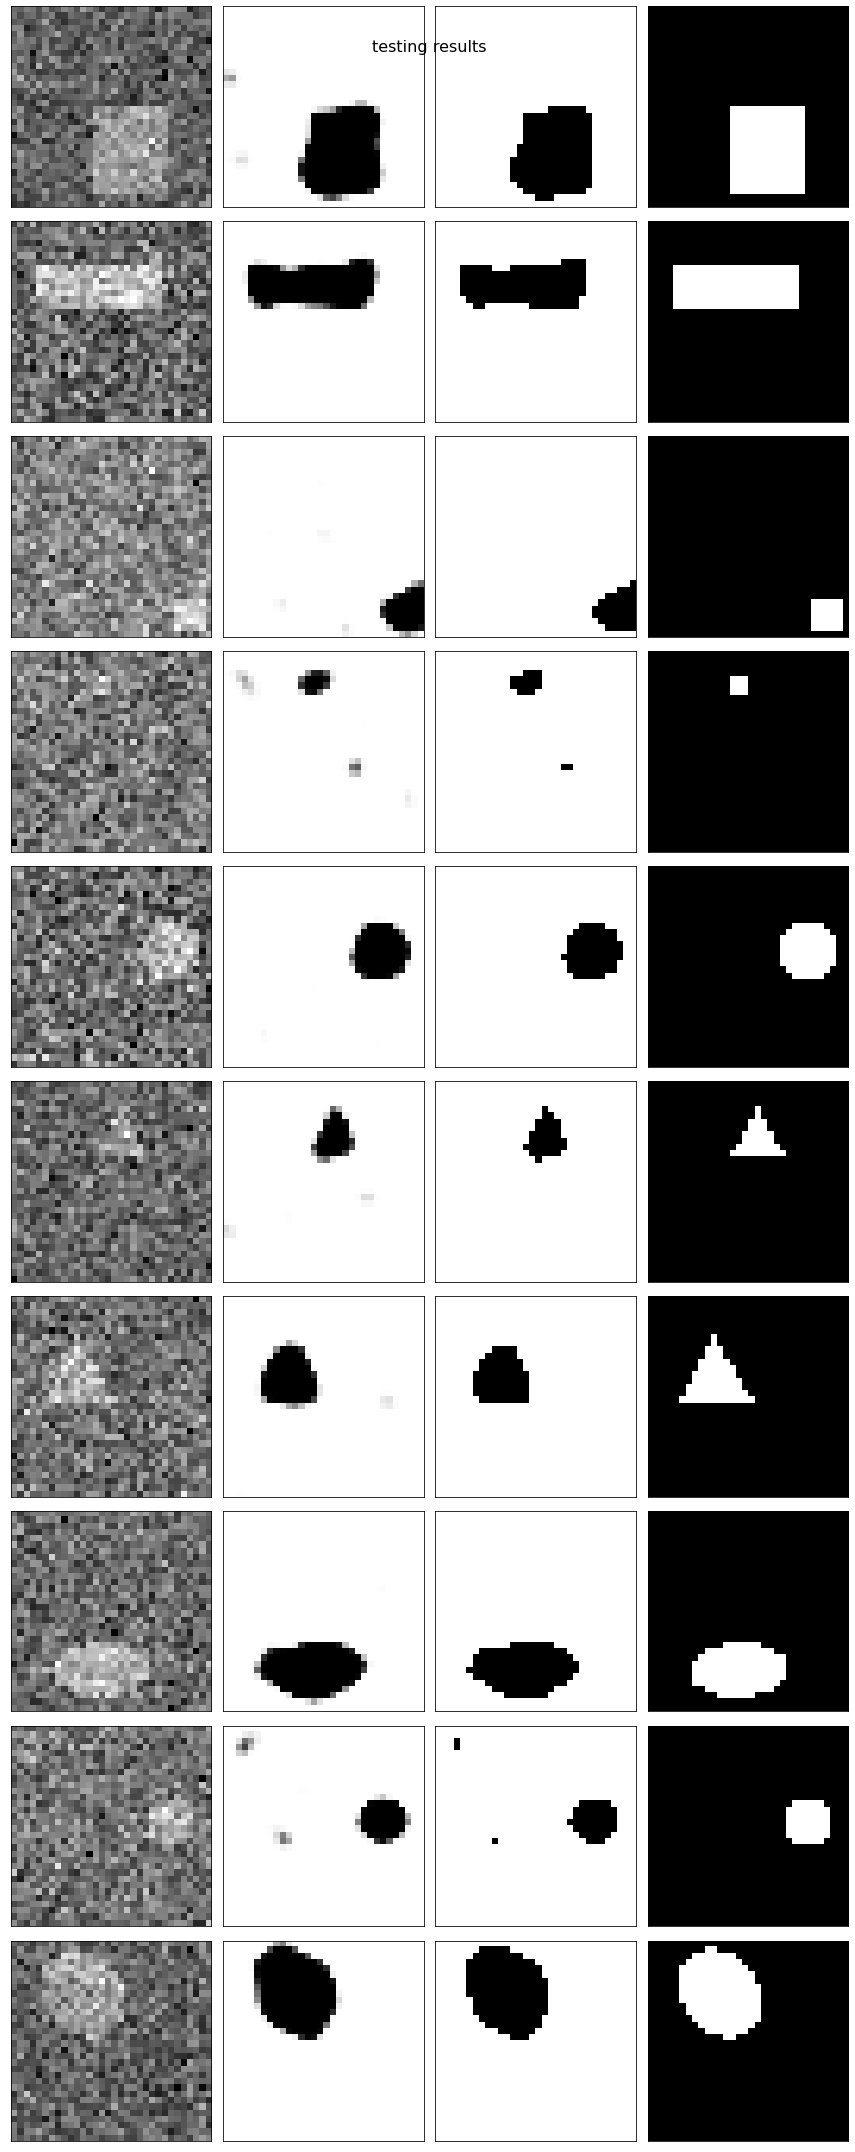


################################################################################
#
# RESULT # 11
#
################################################################################

final training accuracy = 31.74235344

################################################################################
#
# RESULT # 12
#
################################################################################

final testing accuracy = 75.04390717


In [37]:
number_result = 12 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)

In [38]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,038 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:1

In [39]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain

In [41]:
!jupyter nbconvert --to PDF '/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_10.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_10.ipynb to PDF
[NbConvertApp] Support files will be in assignment_10_files/
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Making directory ./assignment_10_files
[NbConvertApp] Writing 141734 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.